# Setting Parameters

In [4]:
# Params
RANDOM_SEED = 45
BATCH_SIZE = 64

# Loading Packages

In [5]:
# Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

# Loading Data

## Prep Data into DataFrame

In [38]:
# download from kaggle
# First check if the dataset is already downloaded
if not os.path.exists('./data/cartoon-faces-googles-cartoon-set.zip'):
    # Download the dataset
    !pip install kaggle
    !kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set -p ./data
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [14]:
# unzip files in python
import zipfile

# get current directory
home_dir = os.getcwd()

# unzip
with zipfile.ZipFile(home_dir + '/data/cartoon-faces-googles-cartoon-set.zip', 'r') as zip_ref:
    zip_ref.extractall(home_dir + '/data')

In [16]:
# Put file paths in a DataFrame

# initialize dataframe
data = pd.DataFrame(columns=["path"])

# Initialize directory and translate dict (only use first 10k images)
dir = home_dir +  "/data/cartoonset100k_jpg/0"

for subdir in os.listdir(dir):
    data.loc[len(data)] = [dir + "/" + subdir]

data.head()

,path
0,/home/adam-taback/Desktop/APS360/Project/Final...
1,/home/adam-taback/Desktop/APS360/Project/Final...
2,/home/adam-taback/Desktop/APS360/Project/Final...
3,/home/adam-taback/Desktop/APS360/Project/Final...
4,/home/adam-taback/Desktop/APS360/Project/Final...


## Load into PyTorch

In [17]:
# import packages
from torch.utils.data import Dataset
from PIL import Image

### Define Dataset Class

In [21]:
# Define Dataset
class CartoonDataset(Dataset):
    def __init__(self, X, transform=None):
        self.X = np.asarray(X).ravel()
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        # print(f"Opening image: {img_path}")
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img


    def show_img(self, idx):
        '''Plot image'''
        img = self.__getitem__(idx)
        if img is not None:
            img = img.numpy().transpose((1, 2, 0))
            plt.figure(figsize=(16, 8))
            plt.axis('off')
            plt.imshow(img)
            plt.pause(0.001)

### Define Transforms

In [22]:
# Define Transforms
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

### Generate Datasets and Plot examples

In [23]:
# Generate DataSets

cartoon_set = CartoonDataset(data["path"],transform=transform)

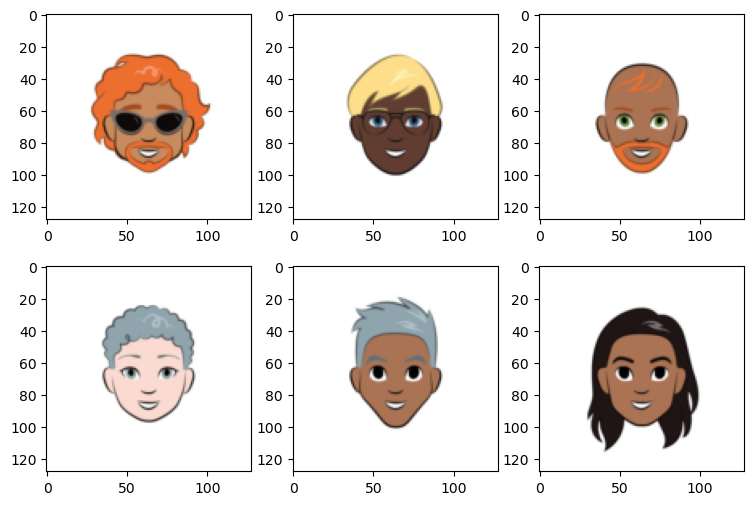

In [25]:
# Plot first 9 images

# define plot
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

# iterate
for i in range(2):
  for j in range(3):
    img = cartoon_set[i*3 + j]
    img = img.numpy().transpose((1, 2, 0))
    axes[i,j].imshow(img)

### Prep Dataloaders

In [26]:
# make dataloader
from torch.utils.data import DataLoader

cartoon_loader = DataLoader(cartoon_set, batch_size=BATCH_SIZE, shuffle=False)

# Baseline Model

## Define Model Class

# Primary Model

In [27]:
# import packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils

In [29]:
# Can only use CPU as GPU gives wierd error
device = "cpu"
device

'cpu'

## Generator

In [30]:
# Define the Encoder
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x64x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x16x16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # Output: 256x8x8
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  # Output: 512x4x4
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
    
    def forward(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h))
        h = torch.relu(self.conv3(h))
        h = torch.relu(self.conv4(h))
        h = torch.relu(self.conv5(h))
        h = h.view(h.size(0), -1)  # Flatten
        h = torch.relu(self.fc1(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1024)
        self.fc2 = nn.Linear(1024, 512 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # Output: 256x8x8
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x16x16
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x32x32
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x64x64
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # Output: 3x128x128
    
    def forward(self, z):
        h = torch.relu(self.fc(z))
        h = torch.relu(self.fc2(h))
        h = h.view(h.size(0), 512, 4, 4)
        h = torch.relu(self.deconv1(h))
        h = torch.relu(self.deconv2(h))
        h = torch.relu(self.deconv3(h))
        h = torch.relu(self.deconv4(h))
        x_recon = torch.sigmoid(self.deconv5(h))
        return x_recon

# Define the VAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
    
    def sample(self, num_samples, z):
        # Sample points in z and decode them
        samples = self.decoder(z)
        return samples


# Loss function
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

## Training

Function to save images at each epoch

In [31]:
# import vutils
import torchvision.utils as vutils

def plot_generated_images(vae, fixed_noise, epoch):
    # Generate reconstructed images with the VAE
    vae.eval()  # Set the VAE to evaluation mode
    with torch.no_grad():
        generated_images = vae.decoder(fixed_noise).detach().cpu()

    # Create a grid of generated images
    grid = vutils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
    
    # Plotting the images
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images from Epoch {epoch}")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    
    # Save the frame
    plt.savefig(f"vae_training_frames/epoch_{epoch}.png")
    plt.close()


training loop

In [32]:
# Hyperparameters
latent_dim = 15
lr = 5e-4
batch_size = BATCH_SIZE
epochs = 35
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model and optimizer
vae = ConvVAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Directory to save frames
os.makedirs("vae_training_frames", exist_ok=True)

# Fixed noise for generating images
fixed_noise = torch.randn(32, latent_dim).to(device)

for epoch in range(epochs):
    # REMOVE THIS LINE TO RETRAIN THE MODEL
    # Check if model has already reached the epoch
    if os.path.exists(f"models/cartoon_vae/vae_epoch_{epoch + 1}.pth"):
        print(f"Model already trained for epoch {epoch + 1}")
        
        # Load model
        vae.load_state_dict(torch.load(f"models/cartoon_vae/vae_epoch_{epoch + 1}.pth"))
        
        # Generate and plot images
        plot_generated_images(vae, fixed_noise, epoch + 1)
        
        continue
    
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(cartoon_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(data)
        loss = vae_loss(data, x_recon, mu, logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(cartoon_loader.dataset)}')
    
    # Plot images after each epoch using the function
    plot_generated_images(vae, fixed_noise, epoch + 1)
        
    # Save model after each epoch
    torch.save(vae.state_dict(), f"models/cartoon_vae/vae_epoch_{epoch + 1}.pth")

print("Training complete!")

# Create an animation
frames = []
for epoch in range(epochs):
    frame = Image.open(f"vae_training_frames/epoch_{epoch + 1}.png")
    frames.append(frame)

# Save as GIF
frames[0].save('vae_training_animation.gif', format='GIF',
               append_images=frames[1:], save_all=True, duration=300, loop=0)

Model already trained for epoch 1
Model already trained for epoch 2
Model already trained for epoch 3
Model already trained for epoch 4
Model already trained for epoch 5
Model already trained for epoch 6
Model already trained for epoch 7
Model already trained for epoch 8
Model already trained for epoch 9
Model already trained for epoch 10
Model already trained for epoch 11
Model already trained for epoch 12
Model already trained for epoch 13
Model already trained for epoch 14
Model already trained for epoch 15
Model already trained for epoch 16
Model already trained for epoch 17
Model already trained for epoch 18
Model already trained for epoch 19
Model already trained for epoch 20
Model already trained for epoch 21
Model already trained for epoch 22
Model already trained for epoch 23
Model already trained for epoch 24
Model already trained for epoch 25
Model already trained for epoch 26
Model already trained for epoch 27
Model already trained for epoch 28
Model already trained for epo

# Plotting Final Images

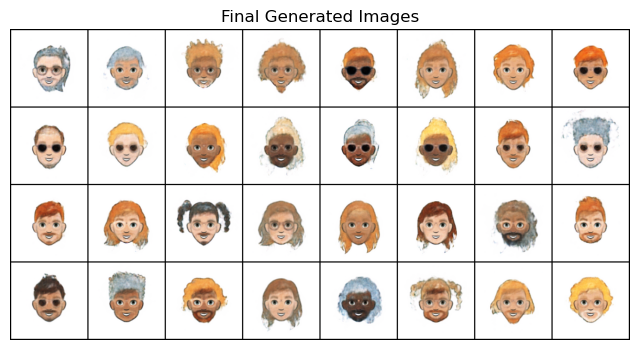

In [34]:
# load model
device = "cpu"

vae = ConvVAE(latent_dim).to(device)

vae.load_state_dict(torch.load("models/cartoon_vae/vae_epoch_35.pth"))

# Generate images
fixed_noise = torch.randn(32, latent_dim).to(device)
generated_images = vae.decoder(fixed_noise).detach().cpu()

# Create a grid of generated images
grid = vutils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

# Plotting the images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Final Generated Images")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))

# Calculating Frechet Inception Distance

In [35]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch.nn.functional as F

def calculate_fid(real_images, generated_images, batch_size=32):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()

    def get_activations(images):
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            pred = model(images)
        return pred.cpu().numpy()

    real_activations = get_activations(real_images)
    generated_activations = get_activations(generated_images)

    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = generated_activations.mean(axis=0), np.cov(generated_activations, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [39]:
# Calculate FID

sample_size = 1000

# First get real images
real_images = []
for i in range(sample_size):
    img = cartoon_set[i]
    real_images.append(img)
    
real_images = torch.stack(real_images).to(device)

# Get newly generated images
fixed_noise = torch.randn(sample_size, latent_dim).to(device)
generated_images = vae.decoder(fixed_noise).detach().cpu()

# Calculate FID
fid = calculate_fid(real_images, generated_images)

/home/adam-taback/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adam-taback/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(f"FID: {fid}")

(493.7974564479706, 1000)